<a href="https://colab.research.google.com/github/lexxai/goit_python_ds_hw_07/blob/main/goit_python_ds_hw_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Модуль 7. Рекомендаційні системи.

*З циклу [домашніх завдань Python Data Science](https://github.com/lexxai/goit_python_data_sciense_homework).*

# Домашнє завдання

## LOAD DATASET

In [181]:
!pip install scikit-surprise

In [182]:
from surprise.model_selection import cross_validate
from surprise import accuracy, Dataset, SVD
from surprise.model_selection import train_test_split
import pandas as pd

# Load the movielens-100k dataset (download it if needed).
data = Dataset.load_builtin('ml-100k', prompt=False)

In [183]:
!ls -1  /root/.surprise_data/ml-100k/ml-100k/u* | sed  's/\/root\/\.surprise_data\/ml-100k\/ml-100k\///g' | sort

u1.base
u1.test
u2.base
u2.test
u3.base
u3.test
u4.base
u4.test
u5.base
u5.test
ua.base
ua.test
ub.base
ub.test
u.data
u.genre
u.info
u.item
u.occupation
u.user


In [184]:
from pathlib import Path

base_path = Path("/root/.surprise_data/ml-100k/ml-100k")
filelist =  list(map(lambda x: x.name, sorted(base_path.glob("u*"))))
types = {
    "test": "Test_files",
    "base": "Train_files"
}
for f, d in types.items():
   print(f"\n{d}:")
   print(list(filter(lambda x : x.endswith(f".{f}") ,filelist)))


Test_files:
['u1.test', 'u2.test', 'u3.test', 'u4.test', 'u5.test', 'ua.test', 'ub.test']

Train_files:
['u1.base', 'u2.base', 'u3.base', 'u4.base', 'u5.base', 'ua.base', 'ub.base']


In [185]:
type(data)

surprise.dataset.DatasetAutoFolds

Ми використовуємо об'єкт ***DatasetAutoFolds*** у Surprise, це означає, що ми працюємо з набором даних, який вже було розбито на файли (folds) для перехресної перевірки.



Мета цього методу - охопити загальний випадок використання, коли набір даних вже розбито на попередньо визначені складові, наприклад, набір даних movielens-100k ('ml-100k'), який визначає файли u1.base, u1.test, u2.base, u2.test і т.д... Його також можна використовувати, коли ми не хочемо виконувати перехресну перевірку, але все одно хочемо вказати наші навчальні та тестові дані (що в будь-якому випадку зводиться до 1-кратної перехресної перевірки).

### Аналіз записів

In [186]:
from datetime import date

# Access dataset attributes
raw_ratings = data.raw_ratings
print("Number of ratings:", len(raw_ratings))

# Print a sample of raw ratings
print("\nTop 5 samples of raw ratings:")
for rating in raw_ratings[:5]:
  uid, iid, ur, timestamp = rating
  dater = date.fromtimestamp(int(timestamp))
  print(f"UserID: {uid:5}, ItemID: {iid:5}, UserRateForItem: {ur:5}, date: {dater}")

search_uid = uid
count_uid = 5
print(f"\nTop {count_uid} ratings of user: {search_uid}")

for rating in raw_ratings:
  uid, iid, ur, timestamp = rating
  if uid == search_uid:
    dater = date.fromtimestamp(int(timestamp))
    count_uid -= 1;
    print(f"UserID: {uid:5}, ItemID: {iid:5}, UserRateForItem: {ur:5}, date: {dater}")
    if count_uid <= 0:
      break

search_iid = iid
count_iid = 5
print(f"\nTop {count_iid} ratings of item: {search_iid}")

for rating in raw_ratings:
  uid, iid, ur, timestamp = rating
  if iid == search_iid:
    dater = date.fromtimestamp(int(timestamp))
    count_iid -= 1;
    print(f"UserID: {uid:5}, ItemID: {iid:5}, UserRateForItem: {ur:5}, date: {dater}")
    if count_iid <= 0:
      break

Number of ratings: 100000

Top 5 samples of raw ratings:
UserID: 196  , ItemID: 242  , UserRateForItem:   3.0, date: 1997-12-04
UserID: 186  , ItemID: 302  , UserRateForItem:   3.0, date: 1998-04-04
UserID: 22   , ItemID: 377  , UserRateForItem:   1.0, date: 1997-11-07
UserID: 244  , ItemID: 51   , UserRateForItem:   2.0, date: 1997-11-27
UserID: 166  , ItemID: 346  , UserRateForItem:   1.0, date: 1998-02-02

Top 5 ratings of user: 166
UserID: 166  , ItemID: 346  , UserRateForItem:   1.0, date: 1998-02-02
UserID: 166  , ItemID: 328  , UserRateForItem:   5.0, date: 1998-02-02
UserID: 166  , ItemID: 322  , UserRateForItem:   5.0, date: 1998-02-02
UserID: 166  , ItemID: 288  , UserRateForItem:   3.0, date: 1998-02-02
UserID: 166  , ItemID: 258  , UserRateForItem:   4.0, date: 1998-02-02

Top 5 ratings of item: 258
UserID: 26   , ItemID: 258  , UserRateForItem:   3.0, date: 1998-03-31
UserID: 66   , ItemID: 258  , UserRateForItem:   4.0, date: 1997-12-31
UserID: 207  , ItemID: 258  , UserR

Використовуєтьс прямий відгук (Explicit feedback) - це оцінка, яку користувач поставив, щоб висловити свою задоволеність товаром.

Для оцінки що базується на спільній інформації про користувачів  та їхню взаємодію з об'єктами (Collaborative Filtering) вибранно модель матричної факторизації (Matrix Factorization).

## Mоделі матричної факторизації

### Algorithm SVD.

Метод SVD може бути адаптований до наборів даних з неявним зворотним зв'язком (implicit feedback).


- RMSE - root-mean-square error
- MAE - mean absolute error

In [224]:
SEED = 42
algo_cv = {}

# Use the SVD algorithm.
algo = SVD(random_state=SEED)

#### Прогноз

#### Full_trainset та він же і testset. Accuracy RMSE (root-mean-square error).


In [233]:
def data_full_trainset(algo, data):
  algorithm_name = algo.__class__.__name__
  print(f"Algo: {algorithm_name}, UserID: {uid:5}, ItemID: {iid:5}, UserRateForItem: {ur:5}, date: {dater}")

  #trainset, testset = train_test_split(data, test_size=0.25)
  trainset = data.build_full_trainset()

  print("Number of train ratings:", len(list(trainset.all_ratings())))
  algo.fit(trainset)
  pred = algo.predict(uid, iid, r_ui=ur, verbose=True)

  testset = trainset.build_testset()
  print("Number of test ratings:", len(testset))

  predictions = algo.test(testset)
  # RMSE має бути низьким, оскільки ми є упередженими
  accuracy.rmse(predictions, verbose=True)  # ~ 0.68 (що є низьким показником)

In [234]:
data_full_trainset(algo, data)

Algo: SVD, UserID: 224  , ItemID: 258  , UserRateForItem:   2.0, date: 1997-12-28
Number of train ratings: 100000
user: 224        item: 258        r_ui = 2.00   est = 3.17   {'was_impossible': False}
Number of test ratings: 100000
RMSE: 0.6752


#### Train_test_split 25%. Accuracy RMSE (root-mean-square error).


In [235]:
def data_train_test_split(algo, data, test_size=0.25):
  algorithm_name = algo.__class__.__name__
  print(f"Algo: {algorithm_name}, UserID: {uid:5}, ItemID: {iid:5}, UserRateForItem: {ur:5}, date: {dater}")
  trainset, testset = train_test_split(data, test_size=test_size)

  print("Number of train ratings:", len(list(trainset.all_ratings())))
  algo.fit(trainset)
  pred = algo.predict(uid, iid, r_ui=ur, verbose=True)

  print("Number of test ratings:", len(testset))

  predictions = algo.test(testset)
  # RMSE має бути більшим
  accuracy.rmse(predictions, verbose=True)  # ~ 0.94 (що є високим показником)

In [236]:
data_train_test_split(algo, data)

Algo: SVD, UserID: 224  , ItemID: 258  , UserRateForItem:   2.0, date: 1997-12-28
Number of train ratings: 75000
user: 224        item: 258        r_ui = 2.00   est = 3.65   {'was_impossible': False}
Number of test ratings: 25000
RMSE: 0.9423


#### Cross Validate, cv = 5

In [237]:
import numpy as np

def data_cross_validate(algo, data, cv=5):
  algorithm_name = algo.__class__.__name__
  print(f"Algo: {algorithm_name}. Cross Validate: {cv}")
  # Run 5-fold cross-validation and print results.
  cv_result = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=cv, verbose=True)
  mean_rmse = np.array(cv_result.get('test_rmse')).mean()
  print(f"{mean_rmse=}")
  return {algorithm_name: mean_rmse}

In [238]:
algo_cv.update(data_cross_validate(algo, data))

Algo: SVD. Cross Validate: 5
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9408  0.9331  0.9375  0.9364  0.9355  0.9367  0.0025  
MAE (testset)     0.7428  0.7372  0.7374  0.7378  0.7391  0.7389  0.0021  
Fit time          1.45    1.43    1.40    1.72    1.64    1.53    0.13    
Test time         0.19    0.13    0.13    0.22    0.13    0.16    0.04    
mean_rmse=0.9366566146279542


### Algorithm KNNBasic.

In [242]:
from surprise import KNNBasic

# Build an algorithm, and train it.
algo = KNNBasic()

In [243]:
data_full_trainset(algo, data)

Algo: KNNBasic, UserID: 224  , ItemID: 258  , UserRateForItem:   2.0, date: 1997-12-28
Number of train ratings: 100000
Computing the msd similarity matrix...
Done computing similarity matrix.
user: 224        item: 258        r_ui = 2.00   est = 3.35   {'actual_k': 40, 'was_impossible': False}
Number of test ratings: 100000
RMSE: 0.7781


In [244]:
data_train_test_split(algo, data)

Algo: KNNBasic, UserID: 224  , ItemID: 258  , UserRateForItem:   2.0, date: 1997-12-28
Number of train ratings: 75000
Computing the msd similarity matrix...
Done computing similarity matrix.
user: 224        item: 258        r_ui = 2.00   est = 3.60   {'actual_k': 40, 'was_impossible': False}
Number of test ratings: 25000
RMSE: 0.9820


In [245]:
algo_cv.update(data_cross_validate(algo, data))

Algo: KNNBasic. Cross Validate: 5
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9768  0.9713  0.9811  0.9755  0.9830  0.9775  0.0041  
MAE (testset)     0.7709  0.7682  0.7740  0.7697  0.7782  0.7722  0.0035  
Fit time          0.36    0.35    0.33    0.35    0.37    0.35    0.01    
Test time         4.12    3.08    3.09    3.91    3.10    3.46    0.46    
mean_rmse=0.9775457372186199


### Algorithm SVD++ (SVDpp)

Алгоритм SVD++ можна використовувати, коли ми маємо доступ як до явного (explicit), так і до неявного (implicit) зворотного зв'язку. Це може бути дуже корисно, тому що зазвичай користувачі взаємодіють з багатьма елементами (= неявний зворотній зв'язок), але оцінюють лише невелику підмножину з них (= явний зворотній зв'язок).


In [ ]:
 # surprise.prediction_algorithms.matrix_factorization.SVDpp
from surprise import SVDpp

# Use the SVDpp algorithm.
algo = SVDpp()

In [ ]:
data_full_trainset(algo, data)

In [ ]:
data_train_test_split(algo, data)

In [ ]:
algo_cv.update(data_cross_validate(algo, data))

### Algorithm NMF

In [250]:
# surprise.prediction_algorithms.matrix_factorization.NMF
from surprise import NMF

# Use the NMF algorithm.
algo = NMF()

In [251]:
data_full_trainset(algo, data)

Algo: NMF, UserID: 224  , ItemID: 258  , UserRateForItem:   2.0, date: 1997-12-28
Number of train ratings: 100000
user: 224        item: 258        r_ui = 2.00   est = 3.45   {'was_impossible': False}
Number of test ratings: 100000
RMSE: 0.8227


In [252]:
data_train_test_split(algo, data)

Algo: NMF, UserID: 224  , ItemID: 258  , UserRateForItem:   2.0, date: 1997-12-28
Number of train ratings: 75000
user: 224        item: 258        r_ui = 2.00   est = 3.22   {'was_impossible': False}
Number of test ratings: 25000
RMSE: 0.9762


In [253]:
algo_cv.update(data_cross_validate(algo, data))

Algo: NMF. Cross Validate: 5
Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9580  0.9583  0.9574  0.9709  0.9716  0.9632  0.0066  
MAE (testset)     0.7551  0.7527  0.7530  0.7616  0.7649  0.7575  0.0049  
Fit time          2.09    2.60    2.06    2.08    2.07    2.18    0.21    
Test time         0.11    0.20    0.11    0.12    0.12    0.13    0.03    
mean_rmse=0.9632386209754499


## Результати кросвалідації для різних алгоритмів матричної факторизації

In [254]:
algo_cv

{'SVD': 0.9366566146279542,
 'KNNBasic': 0.9775457372186199,
 'SVDpp': 0.9195611554025968,
 'NMF': 0.9632386209754499}

In [265]:
algo_cv_s = dict(sorted(algo_cv.items(), key=lambda x: x[1]))


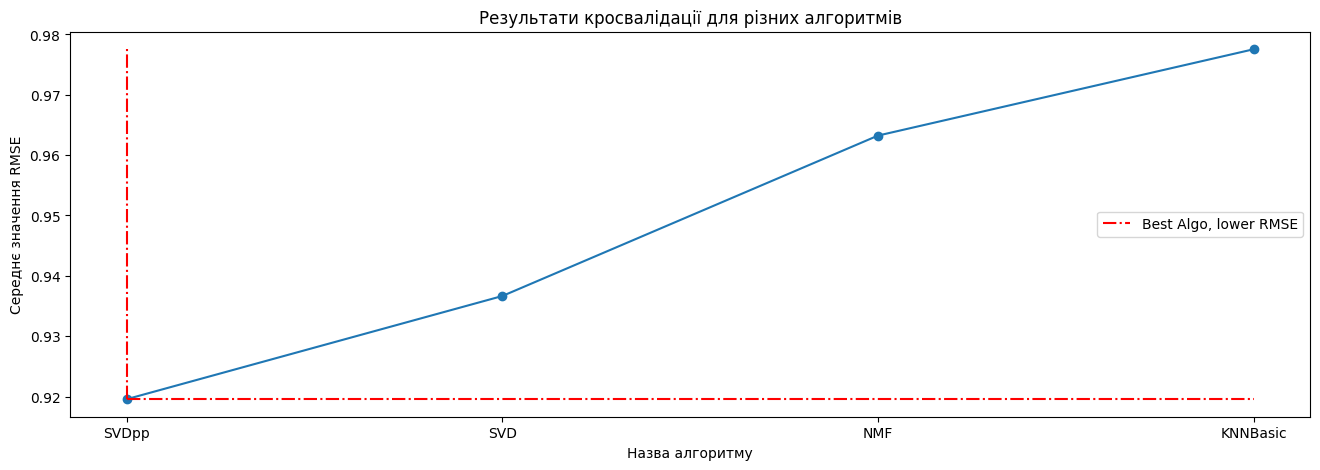

In [314]:
import matplotlib.pyplot as plt

x = list(algo_cv_s.keys())
y = list(algo_cv_s.values())
plt.figure(figsize=(16, 5))
plt.title("Результати кросвалідації для різних алгоритмів")
plt.plot(x, y, "o-")
plt.xlabel("Назва алгоритму")
plt.ylabel("Середнє значення RMSE")
plt.vlines(x[0], y[0], y[-1], color="red", linestyle="-.", label="Best Algo, lower RMSE")
plt.hlines(y[0], x[0], x[-1], color="red", linestyle="-.", )

plt.legend(loc="center right")
plt.show()

In [334]:
print(f"Best algo: {x[0]}, with RMSE: {y[0]:.4f}")

Best algo: SVDpp, with RMSE: 0.9196


In [ ]:
best_algo = SVDpp

## GridSearchCV (SVDpp)

In [336]:
from surprise.model_selection import GridSearchCV

param_grid = {"random_state": [SEED],
              "n_epochs": [15, 20], "lr_all": [0.007], "reg_all": [0.02, 0.2]
              }
gs = GridSearchCV(best_algo, param_grid, measures=["rmse"], cv=5, n_jobs=-1)

%time gs.fit(data)

# best RMSE score
print(gs.best_score["rmse"])

# combination of parameters that gave the best RMSE score
best_params = gs.best_params["rmse"]
print(f"{best_params=}")

0.9176930973292479
best_params={'random_state': 42, 'n_epochs': 15, 'lr_all': 0.007, 'reg_all': 0.02}


#### Звіт роботи GridSearchCV для всіх комбінацій параметрів

In [337]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head(10)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_random_state,param_n_epochs,param_lr_all,param_reg_all
0,0.914383,0.914344,0.923263,0.916318,0.920158,0.917693,0.003498,1,32.797209,0.471785,6.631619,0.333615,"{'random_state': 42, 'n_epochs': 15, 'lr_all':...",42,15,0.007,0.02
1,0.916977,0.915574,0.923985,0.917307,0.921287,0.919026,0.003123,2,44.830591,1.146526,6.035298,0.787245,"{'random_state': 42, 'n_epochs': 20, 'lr_all':...",42,20,0.007,0.02
2,0.925468,0.923226,0.931288,0.925301,0.929070,0.926870,0.002901,3,50.805933,7.701918,4.810882,1.093525,"{'random_state': 42, 'n_epochs': 25, 'lr_all':...",42,25,0.007,0.02


#### навчання на full_trainset для найкращого алгоритму

In [342]:
# We can now use the algorithm that yields the best rmse:
algo = gs.best_estimator["rmse"]

## Найкращі рекомендації для користувачів (SVDpp):

In [339]:
from collections import defaultdict


def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [340]:
# First train an SVD algorithm on the movielens dataset.
trainset = data.build_full_trainset()

# # best value from GridSearchCV
# algo_param = {'random_state': SEED, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}
print(algo.__class__.__name__, "params:", best_params)
# algo = SVDpp(**algo_param)
%time algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
%time predictions = algo.test(testset)

SVDpp params: {'random_state': 42, 'n_epochs': 15, 'lr_all': 0.007, 'reg_all': 0.02}


In [343]:
recomendations = 5
top_n = get_top_n(predictions, n=recomendations)

counter=15
# Print the recommended items for each user
print(f"Найкращі рекомендації для перших {counter} користувачів:\n")

for uid, user_ratings in top_n.items():
    recomend = [f"{iid:5}: {'*'*round(est):5} ({est:.2f})" for (iid, est) in user_ratings]
    print(f"Для користувача: {uid:5} ,  Найкращі {recomendations} рекомендацій: {recomend}")
    counter -= 1
    if counter <=0:
      break

Найкращі рекомендації для перших 15 користувачів:

Для користувача: 196   ,  Найкращі 5 рекомендацій: ['318  : ****  (4.44)', '169  : ****  (4.43)', '408  : ****  (4.37)', '483  : ****  (4.33)', '515  : ****  (4.29)']
Для користувача: 186   ,  Найкращі 5 рекомендацій: ['318  : ****  (4.49)', '174  : ****  (4.38)', '64   : ****  (4.37)', '143  : ****  (4.34)', '169  : ****  (4.31)']
Для користувача: 22    ,  Найкращі 5 рекомендацій: ['169  : ***** (4.94)', '64   : ***** (4.85)', '408  : ***** (4.77)', '199  : ***** (4.75)', '313  : ***** (4.74)']
Для користувача: 244   ,  Найкращі 5 рекомендацій: ['127  : ***** (5.00)', '408  : ***** (4.95)', '187  : ***** (4.92)', '12   : ***** (4.89)', '1449 : ***** (4.87)']
Для користувача: 166   ,  Найкращі 5 рекомендацій: ['169  : ***** (4.66)', '318  : ***** (4.64)', '174  : ***** (4.63)', '408  : ***** (4.58)', '22   : ***** (4.57)']
Для користувача: 298   ,  Найкращі 5 рекомендацій: ['408  : ***** (4.68)', '169  : ***** (4.67)', '64   : ***** (4